# Data Exploration Notebook

## Objectives

* Perform univariate, bivariate and correlation analyses to explore the dataset’s structure, identify key relationships between variables and generate insights relevant to Business Requirement 1
    * Business Requirement 1: Data Insights (Conventional Analysis)  
        Identify key customer and loan attributes that are most correlated with loan default. Provide visual and statistical insights to help business analysts understand the primary drivers of credit risk.

## Inputs

* outputs/datasets/collection/LoanDefaultData.csv

## Outputs

* Generate code that answers Business Requirement 1 and can be used within the Streamlit App


---

In [1]:
# Ignore FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Change working directory

We need to change the working directory from its current folder, where the notebook is stored, to its parent folder
* First we access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\kathr\\Nextcloud\\Dokumente\\Karriere\\Projekte\\vscode-projects\\PP5\\LoanGuard\\jupyter_notebooks'

* Then we want to make the parent of the current directory the new current directory
    * os.path.dirname() gets the parent directory
    * os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print(f"You set a new current directory: {current_dir}")

You set a new current directory: c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard


---

# Load Data

In [4]:
import pandas as pd
df = pd.read_csv("outputs/datasets/collection/LoanDefaultData.csv")
    
df.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3


# Data Exploration

In [5]:
target_var = "loan_status"

## Univariate Analysis

In this section we examine each variable individually, understand its distribution and check for missing levels. This helps us get a clear overview of the dataset before moving on to relationships between variables.

In [6]:
from ydata_profiling import ProfileReport

# Convert object columns to categorical so that it can be displayed properly in the report
df_cat = df.copy()
for col in df_cat.select_dtypes(include='object').columns:
    df_cat[col] = df_cat[col].astype('category')

# Also transform target variable to categorical
df_cat[target_var] = df_cat[target_var].astype('category')
    
pandas_report = ProfileReport(df=df_cat, minimal=True)
pandas_report.to_notebook_iframe() # needs: pip --upgrade setuptools and pip install notebook ipython==8.24.0  ipykernel ipywidgets

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

* The profile report confirmes that missing values exist only in `person_emp_length` and `loan_int_rate`
* It also shows that numerical features exhibit right-skewed distributions with long tails, and that most of the outliers are concentrated on the higher-value end of each variable

To make key observations easier to digest, additional univariate analyses were performed, highlighting distributions, skewness/kurtosis and class balance for both numerical and categorical features.

#### Distribution Analysis of Numerical Variables

In [8]:
import pandas as pd
import numpy as np

num_cols = df_cat.select_dtypes(include=np.number).columns

summary = df_cat[num_cols].describe().T
summary['skewness'] = df_cat[num_cols].skew()
summary['kurtosis'] = df_cat[num_cols].kurtosis()
summary = summary.round(2)

summary

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
person_age,32581.0,27.73,6.35,20.00,23.00,26.00,30.00,144.00,2.58,18.56
person_income,32581.0,66074.85,61983.12,4000.00,38500.00,55000.00,79200.00,6000000.00,32.87,2693.27
person_emp_length,31686.0,4.79,4.14,0.00,2.00,4.00,7.00,123.00,2.61,43.72
loan_amnt,32581.0,9589.37,6322.09,500.00,5000.00,8000.00,12200.00,35000.00,1.19,1.42
loan_int_rate,29465.0,11.01,3.24,5.42,7.90,10.99,13.47,23.22,0.21,-0.67
loan_percent_income,32581.0,0.17,0.11,0.00,0.09,0.15,0.23,0.83,1.06,1.22
cb_person_cred_hist_length,32581.0,5.80,4.06,2.00,3.00,4.00,8.00,30.00,1.66,3.72


* The numerical variables in the dataset generally display **right-skewed distributions with long tails**, as reflected by positive skewness values. Kurtosis values vary across features, with some indicating heavier tails (e.g. `person_income`, `person_age`, and `person_emp_length`), suggesting the presence of outliers, particularly at the higher end of the distributions.  
* Comparing the mean values between features shows substantial differences in scale, ranging from over 6,000,000 for `person_income` to around 0.15 for `loan_percent_income`. This highlights the need for **feature scaling** before modeling, as many machine learning algorithms are sensitive to differences in magnitude and may otherwise assign disproportionate importance to larger-scale variables.

The following boxplots confirm these observations:

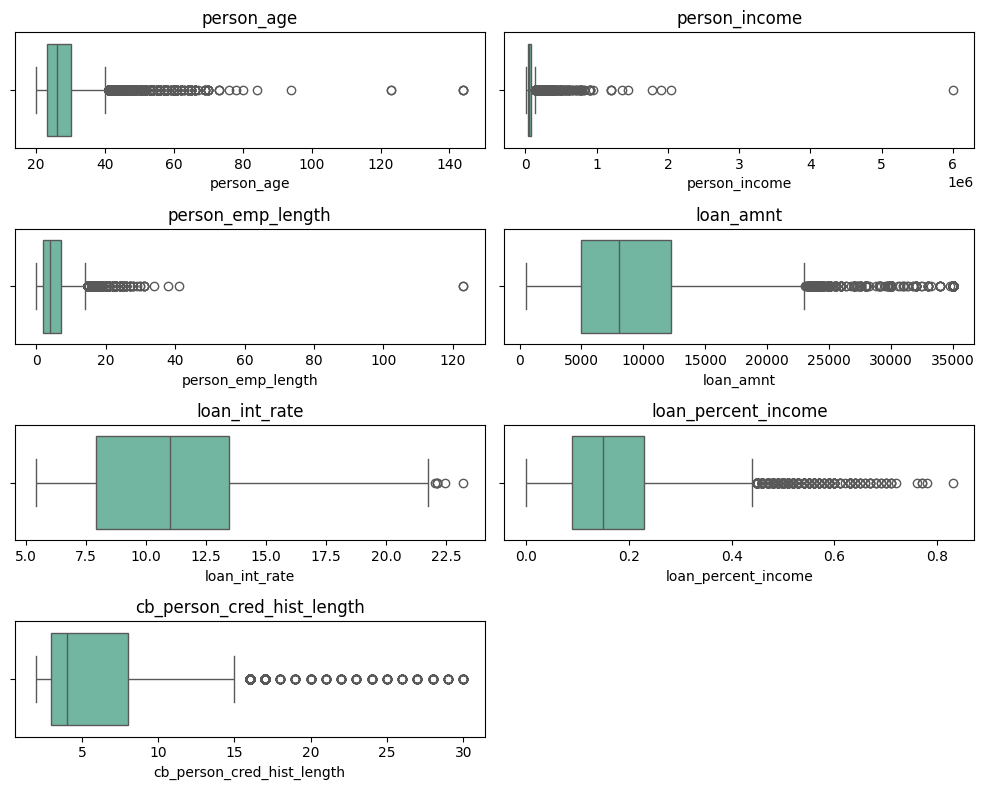

In [9]:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Grid layout for plots
numeric_cols = df_cat.select_dtypes(include=['float64', 'int64']).columns
n_cols = 2
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*2))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df_cat[col], ax=axes[i], color=sns.color_palette("Set2")[0])
    axes[i].set_title(f"{col}")

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

* In addition to the previous observations, the boxplots reveal that all numerical variables contain outliers, with the most pronounced extreme values observed in `person_income`, `person_age`, and `person_emp_length`, consistent with the skewness and kurtosis analysis conducted earlier

In [22]:
import numpy as np
np.sort(df["cb_person_cred_hist_length"].unique())

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], dtype=int64)

#### Distribution Analysis of Categorical Variables

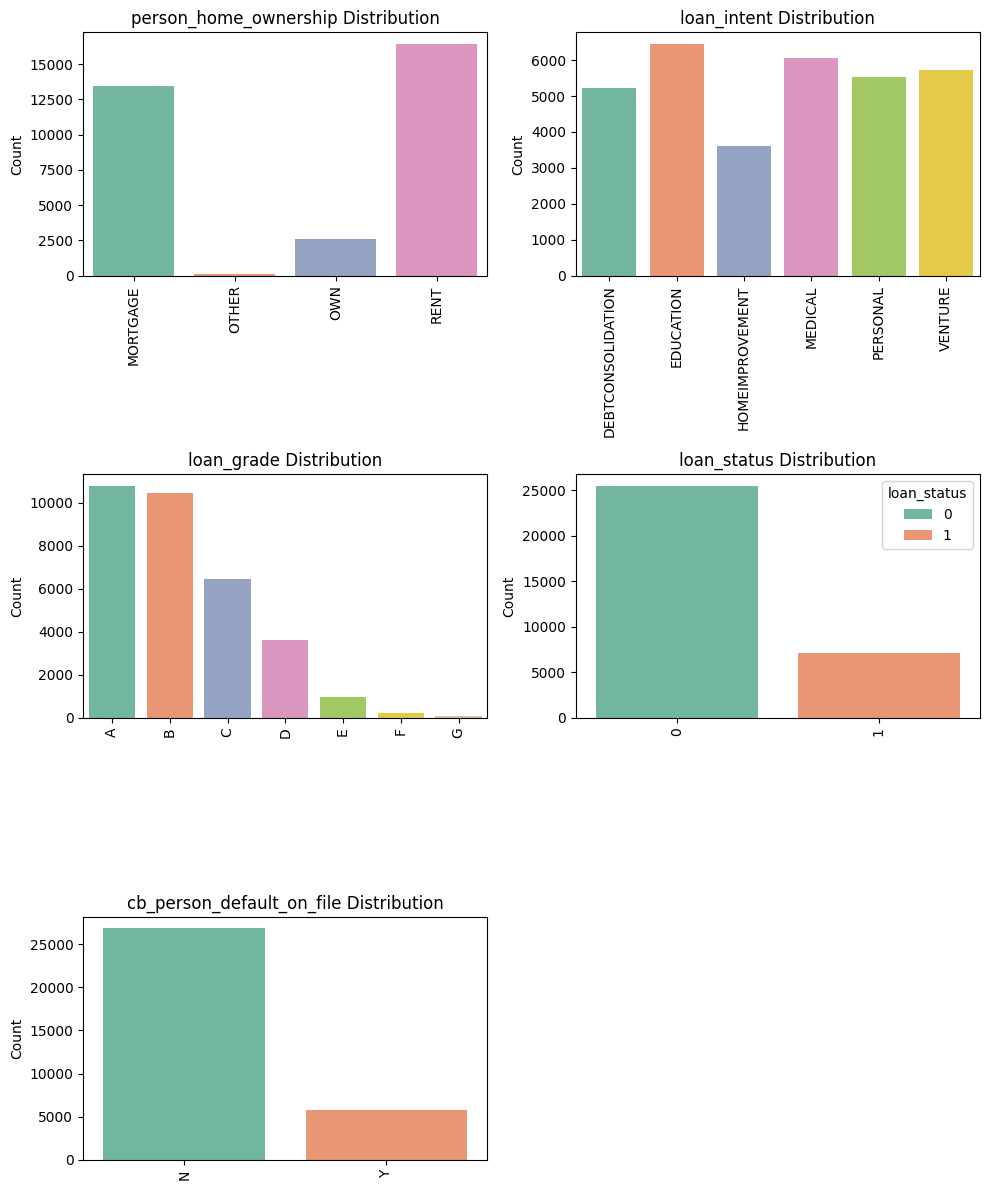

In [10]:
cat_cols = df_cat.select_dtypes(include='category').columns.tolist()

# Grid layout for plots
n_cols = 2
n_rows = (len(cat_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df_cat, ax=axes[i], hue=col, palette='Set2')
    axes[i].set_title(f"{col} Distribution")
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

* The categorical variables in the dataset contain only a small number of distinct classes. This indicates that the features are not overly granular, making them suitable for analysis and modeling.  
* Still some features contain categories with very few observations. These rare categories might have to be addressed during preprocessing. Tree-based models such as Random Forest or XGBoost can generally handle rare categories and imbalances naturally, while linear or logistic models may require explicit handling to avoid unstable coefficients or overfitting.
* An exception are tWe can also see that the target variable `loan_status` is imbalanced toward 0

Overall, the distribution analysis shows that the dataset is generally suitable for modeling, but some considerations are required during preprocessing:  
* **Numerical features** display right-skewed distributions with long tails, and several variables (e.g. `person_income`, `person_age`, `person_emp_length`) contain high-value outliers. Feature scales vary widely, highlighting the need for feature scaling before modeling
* **Categorical features** have a limited number of distinct classes, making them easy to encode. Some categories have very few observations, which may require combining or encoding strategies depending on the model; tree-based models can generally handle these naturally, while linear models may need explicit handling
* **Target variable** `loan_status` is imbalanced toward 0, which should be addressed during model development to ensure reliable predictions


---

## Bivariate Analysis

After examining the univariate distributions to understand each feature individually, the next step is to explore how variables relate to the target variable.

#### Distribution Analysis of Numerical Variables

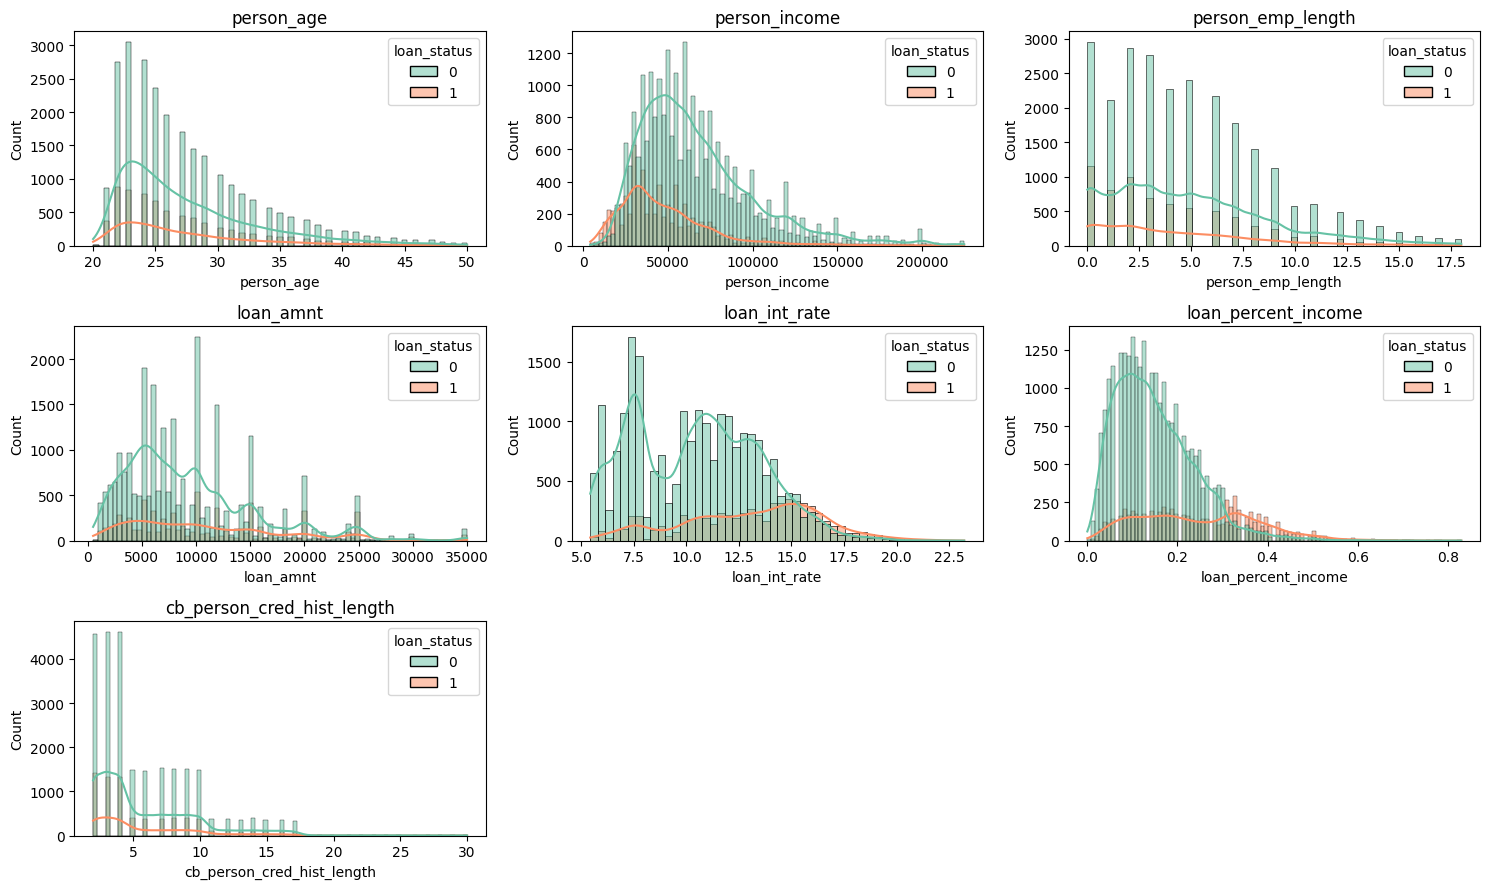

In [11]:
numeric_cols = df_cat.select_dtypes(include=['float64', 'int64']).columns

n_cols = 3  
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*3))
axes = axes.flatten()  

# Define the numeric columns to filter for outliers
outlier_cols = ['person_income', 'person_age', 'person_emp_length']

for i, col in enumerate(numeric_cols):
    # Filter out outliers only for the specified columns
    if col in outlier_cols:
        upper = df_cat[col].quantile(0.99)
        filtered_df = df_cat[df_cat[col] <= upper]
    else:
        filtered_df = df_cat.copy()
        
    sns.histplot(data=filtered_df, x=col, hue=target_var, ax=axes[i], kde=True, palette="Set2")
    axes[i].set_title(f"{col}")

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Distribution Analysis of Categorical Variables

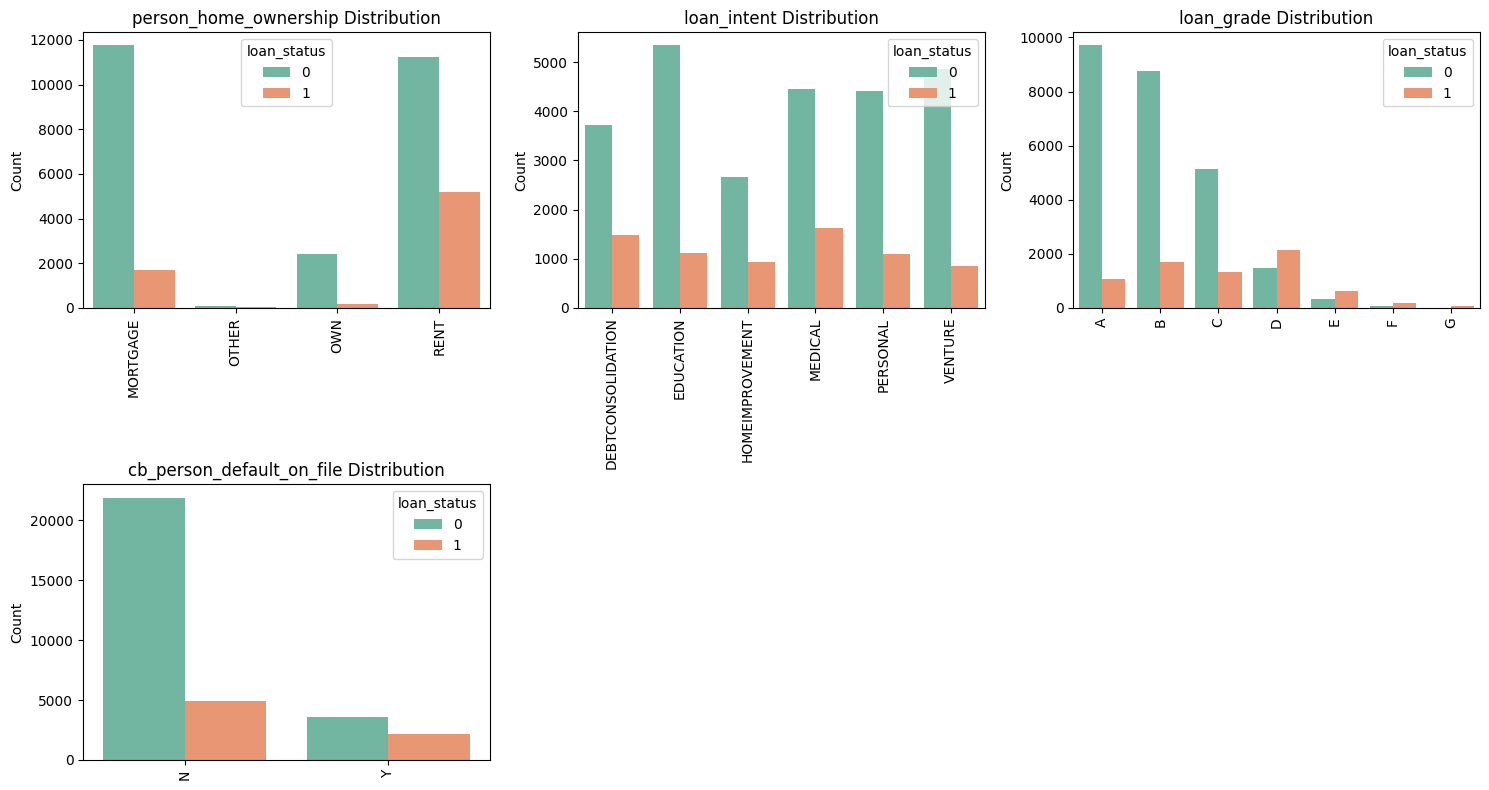

In [12]:
cat_cols = df_cat.select_dtypes(include='category').columns.drop(target_var).tolist()

n_cols = 3
n_rows = (len(cat_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df_cat, ax=axes[i], hue=target_var, palette='Set2')
    axes[i].set_title(f"{col} Distribution")
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

# Remove empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

* The bivariate analysis revealed that several numerical variables, such as `person_income`, `loan_int_rate`, and `person_emp_length`, show clear positive or negative relationships with `loan_status`. This suggests that these features may have some predictive influence on the target variable
* In contrast, categorical variables display much weaker and less consistent patterns, indicating that their effect on `loan_status` is less direct or may depend on interactions with other variables. However, some trends are visible. For example, applicants who **rent their homes** seem more likely to default compared to those who own or have a mortgage

Next, we explore correlation analyses to quantify these relationships and further understand how the features relate to each other and to the target variable.

## Correlation Analysis

Correlation analysis helps identify linear or non-linear relationships between features and with the target variable.

This step provides insights into potential multicollinearity among predictors and highlights which variables may have predictive influence on loan default.
Understanding these relationships is essential for guiding feature selection, hypothesis validation and the design of machine learning models later in the project. We will also use these insights to answer Business Requirement 1.

To explore how features relate to each other and to the target variable, we use three complementary measures:

* Pearson correlation: captures linear relationships
* Spearman correlation: captures monotonic (rank-based) relationships
* Power Predictive Score (PPS): detects non-linear and directional predictive relationships

Since each method provides a different perspective, comparing all three helps ensure we capture both linear and complex dependencies in the data.

The helper functions below automate this process:

* heatmap_corr() → Plots correlation matrices (Pearson or Spearman) masking for low-correlation values
* heatmap_pps() → Plots the PPS matrix masking for low-correlation values
* CalculateCorrAndPPS() → Calculates Pearson, Spearman and PPS matrices and prints descriptive statistics for PPS to help select masking thresholds
* DisplayCorrAndPPS() → Combines all plots in one view to facilitate interpretation and comparison

Together, these functions provide a structured way to assess relationships among variables and evaluate which features may be most predictive of loan default.

In [13]:
# From Churnometer Walkthrough Project
import numpy as np
# for vs code
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.ylabel("")
        plt.xlabel("")
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman", numeric_only=True)
    df_corr_pearson = df.corr(method="pearson", numeric_only=True)

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='y', index='x', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable is correlated with other variables (features and target)")
    print("* Analyse multi-collinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("Evaluates monotonic relationships (continuous variables)\n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("Evaluates linear relationships (continuous variables)\n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two variables\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

In [14]:
# transform target back to integer so that it can be used in pearson and spearman correlation analysis
df_cat[target_var] = df_cat[target_var].astype('int')
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df_cat)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  132.0  0.042  0.137  0.0  0.0  0.0  0.005  0.956


* The PPS (Predictive Power Score) analysis indicates that most variable pairs have **very low predictive power**, with a median and 75th percentile of 0 and 0.005 respectively, and a mean of 0.042. Only a few pairs reach higher values (up to 0.956), suggesting limited but notable predictive potential, but also possible multicollinearity.  

Based on the PPS distribution and its interquartile range, a **threshold of 0.01** was chosen to filter out pairs with effectively zero predictive power while retaining those with even minimal above-average potential for inclusion in the heatmap.

Analogously, for the Pearson and Spearman correlation heatmaps, a threshold of 0.2 was selected to capture the available correlations.



* Analyse how the target variable is correlated with other variables (features and target)
* Analyse multi-collinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
Evaluates monotonic relationships (continuous variables)



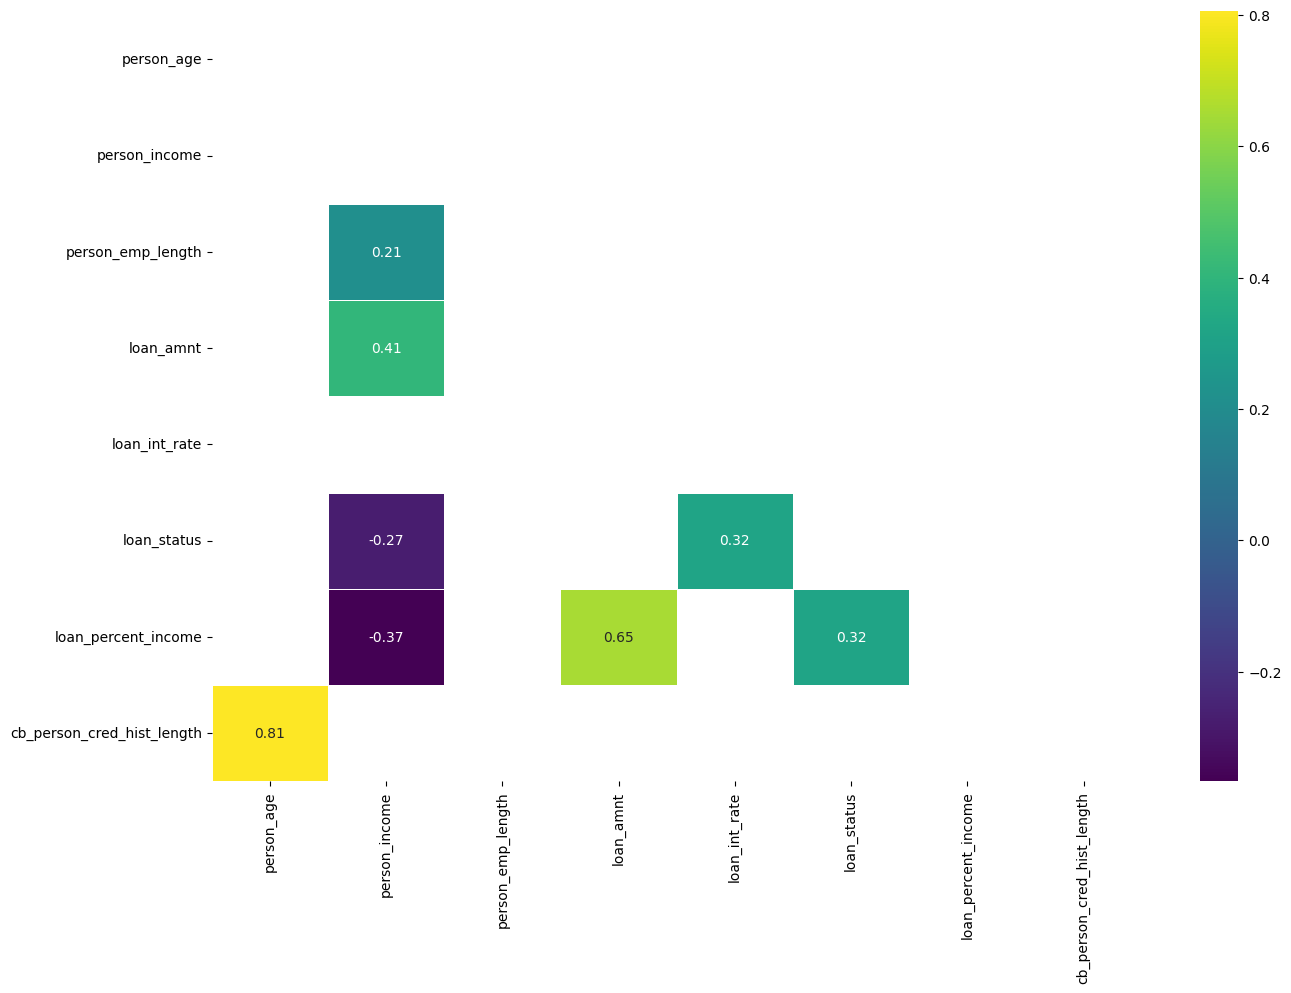



*** Heatmap: Pearson Correlation ***
Evaluates linear relationships (continuous variables)



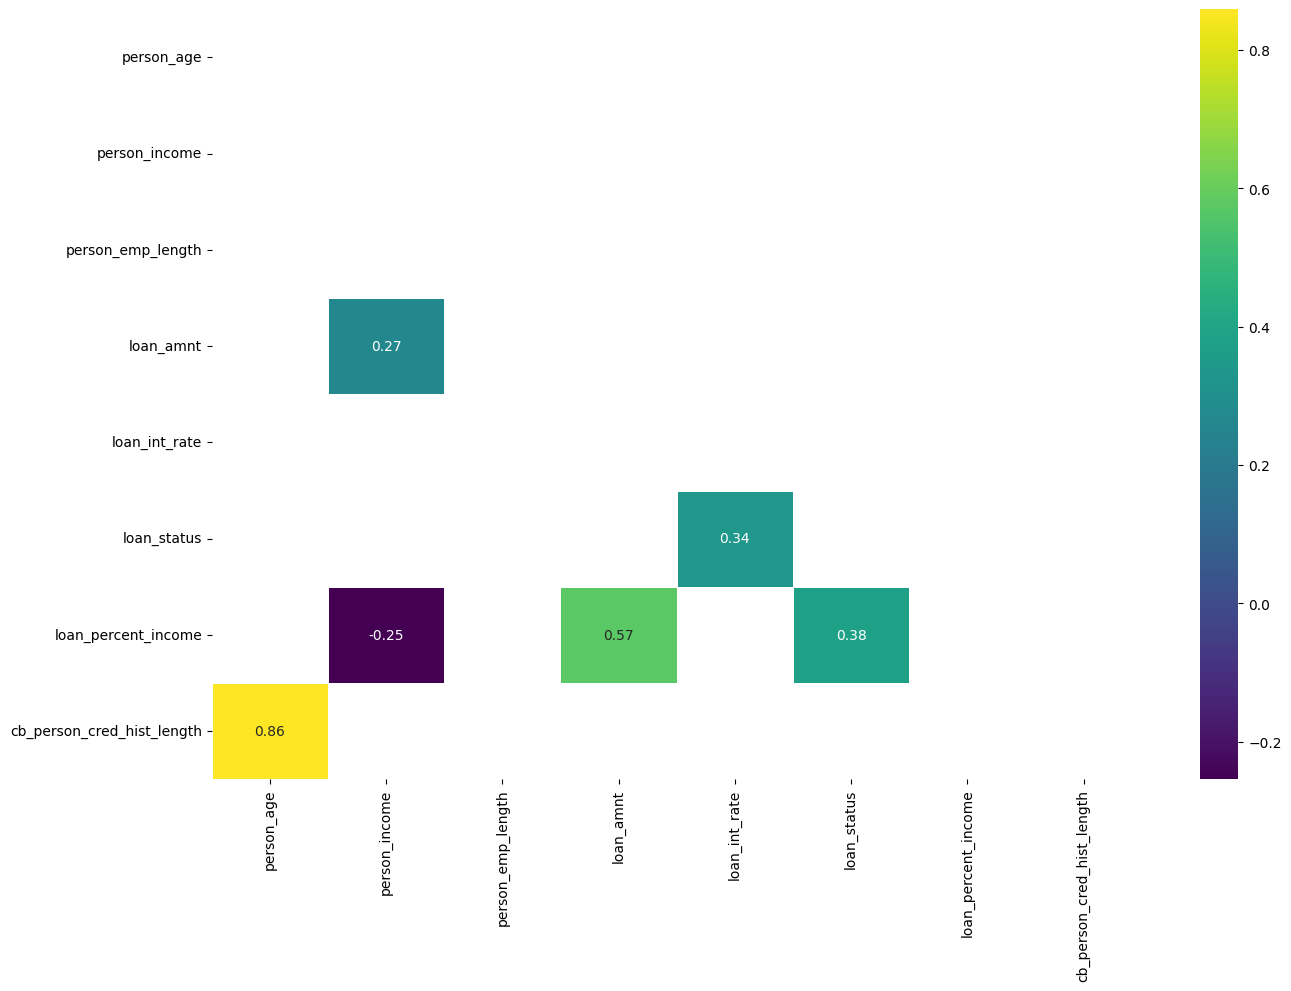



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two variables
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



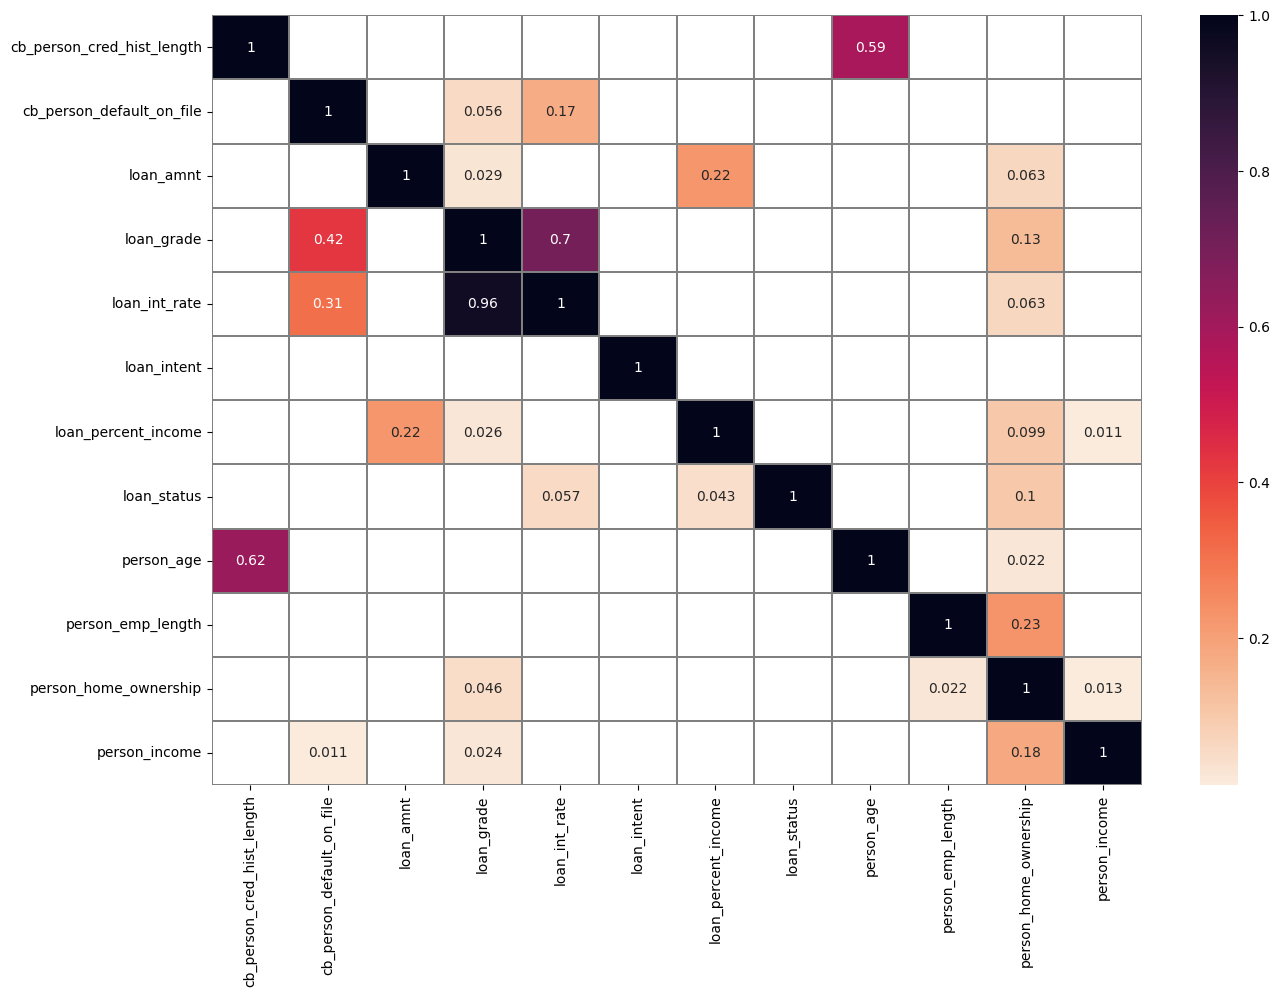

In [15]:
CorrThreshold = 0.2
PPS_Threshold = 0.01
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = CorrThreshold, PPS_Threshold = PPS_Threshold,
                  figsize=(15,10), font_annot=10)

* The correlation and PPS heatmaps indicate that correlations with the target variable `loan_status` remain generally low, suggesting that no single predictor strongly explains default behavior 

* However, several predictors show **high multicollinearity**, including:  
    - `person_age` and `cb_person_cred_hist_length`  
    - `loan_percent_income` and `loan_amnt`  
    - `loan_grade` and `loan_int_rate`

    These relationships are consistent with business expectations — for example, older applicants tend to have longer credit histories, larger loans mtake up a larger amount of peoples income, and higher loan grades are associated with higher interest rates. 

* Overall, while multicollinearity exists among some features, it reflects logical, interpretable relationships rather than data issues, and the default outcome is likely influenced by a combination of factors


The variables that showed at some predictive power on the target variable are listed below, ordered by their PPS.

In [16]:
# Collect variables with some predictive signal from PPS and correlations
pps_vars = pps_matrix.T[target_var][abs(pps_matrix.T[target_var]) > PPS_Threshold].drop(target_var).index
pearson_vars = df_corr_pearson[target_var][abs(df_corr_pearson[target_var]) > CorrThreshold].drop(target_var).index
spearman_vars = df_corr_spearman[target_var][abs(df_corr_pearson[target_var]) > CorrThreshold].drop(target_var).index

# Combine all and remove duplicates
focus_vars = pd.Index(pps_vars).union(pearson_vars).union(spearman_vars)

# Sort by absolute PPS
focus_vars = pps_matrix.T[target_var][focus_vars].sort_values(key=abs, ascending=False)
print("The feature with highest predictive power, ordered by PPS:")
print(focus_vars)

focus_vars = focus_vars.index.tolist()


The feature with highest predictive power, ordered by PPS:
person_home_ownership    0.101125
loan_int_rate            0.056517
loan_percent_income      0.042998
Name: loan_status, dtype: float64


* Overall the correlation analysis confirms the patterns observed in the bivariate analysis

Next we visualize how the identified variables relate to the target. This complements the correlation analysis by showing the actual distributions and highlighting patterns or imbalances that may influence predictive modeling.

NameError: name 'ax_box' is not defined

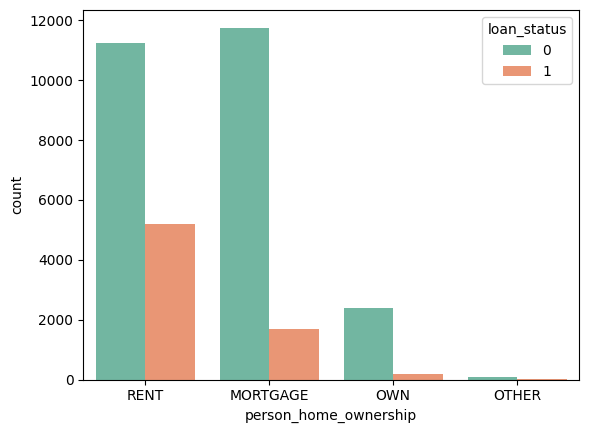

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# target_var = 'Default'
target_var = 'loan_status'

for col in focus_vars:
    if df_cat[col].dtype in ['int64', 'float64']:
        # Create a figure with two stacked axes (boxplot above histogram)
        # Source: https://python-graph-gallery.com/24-histogram-with-a-boxplot-on-top-seaborn/
        fig, (ax_box, ax_hist) = plt.subplots(
            2, 1, 
            figsize=(8, 4), 
            gridspec_kw={"height_ratios": [0.25, 1], "hspace": 0.05}
        )

        # Boxplot (small on top)
        sns.boxplot(data=df_cat, x=col, y=target_var, hue=target_var, orient="h", ax=ax_box, palette="Set2", legend=False)
        ax_box.set(xlabel="")  
        ax_box.set_ylabel("")  
        ax_box.set_title(f"{col} distribution by {target_var}", fontsize=12)

        # Histogram (main plot)
        sns.histplot(data=df_cat, x=col, hue=target_var, kde=True, ax=ax_hist, palette="Set2")
        ax_hist.set_xlabel(col)
        ax_hist.set_ylabel("Count")
        ax_hist.set_title("")
    
    else:
        sns.countplot(data=df_cat, x=col, hue=target_var, palette="Set2", order=df[col].value_counts().index)
        ax_box.set(xlabel="")  
        ax_box.set_ylabel("")  
        ax_box.set_title(f"{col} distribution by {target_var}", fontsize=12)

    plt.show()


* Borrowers who default tend to show the following general trends:
    * Pay rent
    * Have higher interest rates
    * Have a higher loan amount relative to their income
* This doesn't mean all defaulting customers have all these patterns at the same time, we just noticed a general trend

---

# Conclusions and Next Steps

The univariate and correlation analyses provided an initial understanding of the data distribution and key variable relationships with the target.

In the univariate analysis, numerical variables generally display **right-skewed distributions with long tails**, and features such as `person_income`, `person_age`, and `person_emp_length` contain high-value outliers. The scales of numerical features vary widely, indicating the need for **feature scaling**. Categorical variables have a limited number of distinct classes, although some categories have very few observations, which may require handling depending on the model choice. The target variable is  imbalanced toward 0.

The correlations between the features and the target variable are low, which indicates that multicollinearity is not a major concern, but also that no single variable strongly explains loan default.

Bivariate analysis suggests that numerical features such as `person_income`, `loan_int_rate`, and `person_emp_length` show noticeable relationships with the target, while categorical features exhibit weaker patterns, with trends like borrowers who pay rent being more likely to default.

Correlation and PPS analyses reveal that correlations with the target are generally low, but some predictors show high multicollinearity. These relationships are consistent with business logic and indicate that default behavior is influenced by a combination of factors rather than a single feature.

The analysis showed that borrowers who default tend to show the following general trends:
    * Pay rent
    * Have higher interest rates
    * Have a higher loan amount relative to their income

Next Steps:
* Conduct data cleaning activities